In [1]:
ALGORITHM = 'Neural Network'
ALGORITHM_DETAIL = 'random search'
ALGORITHM_DETAIL_ORIG = ALGORITHM_DETAIL
ALGORITHM_DETAIL += ' [input11, d^20-500-500-20-5, dense1]'
DATA_DETAIL = []
#DATA_DETAIL = ['no scale','no dummies']
VERSION = '06'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

OVERRIDE_CV, OVERRIDE_N_ITER, OVERRIDE_JOBS = None, None, None

debug_mode = False
quick_mode = False
quick_mode = True

In [2]:
! pip install scikeras
! pip install catboost

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scikeras.wrappers import KerasClassifier, KerasRegressor

import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

print(tf.__version__)


def make_regression_ann(initializer='uniform', activation='relu', optimizer='adam', loss='mse'):
    normalizer = tf.keras.layers.Normalization(axis=-1)
    model = Sequential()
    #model.add(normalizer)
    model.add(Dense(11, input_shape=(len(X_train[0]),), activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1))
    model.compile(loss=loss, optimizer=optimizer)
    #print(model)
    return model


2022-11-14 21:39:05.940740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


In [4]:
#confirm_colab = True
confirm_colab = False
IN_CLOUD = False

from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())
print(env_vars)

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)
OVERRIDE_CV = env_vars.get('quick_override_cv_splits', None) if quick_mode else None
OVERRIDE_N_ITER = env_vars.get('quick_override_n_iter', None) if quick_mode else None
OVERRIDE_JOBS = env_vars.get('quick_override_n_jobs', None) if quick_mode else None
#if quick_mode:OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10

already_timed = False
no_dummies = 'no dummies' in DATA_DETAIL
no_scaling = 'no scaling' in DATA_DETAIL
not_catboost = 'catboost' not in ALGORITHM.lower() or not no_dummies

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_20221109 import set_csv_directory, get_columns
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time
    from functions_modelling_20221109 import get_results, update_results, get_chosen_model
    from functions_modelling_20221109 import get_hyperparameters

    set_csv_directory('final_split')
else:
    cloud_run = True
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    from functions_20221109 import set_csv_directory, get_columns
    #from functions_20221109 import add_supplements, get_combined_dataset
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time
    from functions_modelling_20221109 import get_results, update_results, get_chosen_model
    from functions_modelling_20221109 import get_hyperparameters

if quick_mode:
    OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10

if 'neural' in ALGORITHM.lower():
    OVERRIDE_JOBS=1

if 'neural' in ALGORITHM.lower() and not cloud_run:
    OVERRIDE_N_ITER = 2

{'notebook_environment': 'local', 'use_gpu': False, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


In [5]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [6]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if cloud_run:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [7]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../data/final/df_listings_v06.csv
(46871, 9)


In [8]:
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD


In [9]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [10]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46871 non-null  float64
 1   bedrooms             46871 non-null  float64
 2   bathrooms            46871 non-null  float64
 3   nearestStation       46871 non-null  float64
 4   location.latitude    46871 non-null  float64
 5   location.longitude   46871 non-null  float64
 6   latitude_deviation   46871 non-null  float64
 7   longitude_deviation  46871 non-null  float64
 8   tenure.tenureType    44127 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [11]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [12]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [13]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895


In [14]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)


(39714, 11) (4413, 11) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [15]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [16]:
starter_pipe = make_modelling_pipeline(KerasRegressor(make_regression_ann, verbose=0), DATA_DETAIL)
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 KerasRegressor(model=<function make_regression_ann at 0x7f2e9e323af0>, verbose=0))])

In [17]:
starter_model = starter_pipe[-1]
default_model_params = starter_model.get_params()
default_model_params

{'model': <function __main__.make_regression_ann(initializer='uniform', activation='relu', optimizer='adam', loss='mse')>,
 'build_fn': None,
 'warm_start': False,
 'random_state': None,
 'optimizer': 'rmsprop',
 'loss': None,
 'metrics': None,
 'batch_size': None,
 'validation_batch_size': None,
 'verbose': 0,
 'callbacks': None,
 'validation_split': 0.0,
 'shuffle': True,
 'run_eagerly': False,
 'epochs': 1}

In [18]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [19]:
# SKIP %timeit starter_pipe.fit(X_train, y_train)

In [31]:
options_block = {
    'model__model__initializer': ['normal'], #, 'uniform'],
    'model__model__activation': ['relu'],
    'model__optimizer': ['adam'],
    'model__loss': ['mse'],
    'model__verbose':[1],
    'model__batch_size': [64, 132] if cloud_run else [1000, 5000],
    'model__epochs': [1000, 5000] if cloud_run else [5,10,15],
}

redundant, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS)


def automl_step(param_options, vary):
    for key, value in param_options.items():
        #print(key, value, vary)
        if key != vary and key != 'model__' + vary:
            param_options[key] = [param_options[key][0]]
    return param_options

options_block = automl_step(options_block, "model__epochs")
pipeline_search_cv = make_modelling_pipeline(KerasRegressor(make_regression_ann, verbose=1), DATA_DETAIL)
    
options_block, cv, n_jobs, refit, n_iter

({'model__model__initializer': ['normal'],
  'model__model__activation': ['relu'],
  'model__optimizer': ['adam'],
  'model__loss': ['mse'],
  'model__verbose': [1],
  'model__batch_size': [1000],
  'model__epochs': [10, 20]},
 3,
 1,
 True,
 2)

In [32]:
def fit_model_with_cross_validation(gs, X_train, y_train, fits):
    pipe_start = time()
    cv_result = gs.fit(X_train, y_train)
    gs.fit(X_train, y_train)
    pipe_end = time()
    average_time = round((pipe_end - pipe_start) / (fits), 2)

    print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
    print()
    print(
        f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
    print(
        f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
    print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

    #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
    return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


crossval_runner = GridSearchCV(
    estimator=pipeline_search_cv,
    param_grid=options_block,
    cv=cv, n_jobs=n_jobs, # get the AVX/AVX2 info if use n_jobs > 2
    verbose=5, scoring=CROSS_VALIDATION_SCORING,
    refit=refit,
    return_train_score=True, #n_iter=n_iter,
    error_score='raise'
)

cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
    crossval_runner, X_train, y_train, fits=cv * n_iter)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Epoch 1/10
27/27 [==============================] - 2s 39ms/step - loss: 192556957696.0000
Epoch 2/10
27/27 [==============================] - 1s 33ms/step - loss: 192393625600.0000
Epoch 3/10
27/27 [==============================] - 1s 35ms/step - loss: 190222696448.0000
Epoch 4/10
27/27 [==============================] - 1s 35ms/step - loss: 173310984192.0000
Epoch 5/10
27/27 [==============================] - 1s 39ms/step - loss: 102250405888.0000
Epoch 6/10
27/27 [==============================] - 1s 44ms/step - loss: 34887364608.0000
Epoch 7/10
27/27 [==============================] - 1s 39ms/step - loss: 24510406656.0000
Epoch 8/10
27/27 [==============================] - 1s 38ms/step - loss: 19941976064.0000
Epoch 9/10
27/27 [==============================] - 1s 43ms/step - loss: 17071387648.0000
Epoch 10/10
27/27 [==============================] - 0s 11ms/step
[CV 1/3] END model__batch_size=1000, model__epochs=10, model

In [33]:
crossval_runner.best_params_

{'model__batch_size': 1000,
 'model__epochs': 20,
 'model__loss': 'mse',
 'model__model__activation': 'relu',
 'model__model__initializer': 'normal',
 'model__optimizer': 'adam',
 'model__verbose': 1}

In [34]:
best_estimator_pipe = crossval_runner.best_estimator_

if debug_mode:
    crossval_runner.cv_results_

In [35]:
cv_results_df = pd.DataFrame(crossval_runner.cv_results_)

cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

cv_columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time','params']
# if 'Neural' not in ALGORITHM:
#     cv_columns.insert(2, 'mean_train_score')

cv_results_df_sorted = cv_results_df.sort_values('rank_test_score')[cv_columns].reset_index(drop=True)
cv_results_df_sorted

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,1000/20/mse/relu/normal/adam/1,1,0.342380,23.549170,0.485042,"{'model__batch_size': 1000, 'model__epochs': 2..."
1,1000/10/mse/relu/normal/adam/1,2,-5.322623,10.490758,0.360912,"{'model__batch_size': 1000, 'model__epochs': 1..."


In [38]:
def print_results(cross_validation_result):
    means = cross_validation_result.cv_results_['mean_test_score']
    stds = cross_validation_result.cv_results_['std_test_score']
    params = cross_validation_result.cv_results_['params']
    times = cross_validation_result.cv_results_['std_test_score']

    print("params:" + "/".join([c.replace("model__", "") for c in params[0].keys()]))
    print()
    for mean, std, param, time in zip(means, stds, params, times):
        #param2 = "/".join(list(param.values()))
        param2 = "/".join(list([str(c) for c in param.values()]))
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) in {round(time, 4)}s for {param2}')


if debug_mode:
    print_results(crossval_runner)

In [39]:
print('Best Index: ', crossval_runner.best_index_)
print('Best Score: ', crossval_runner.best_score_)
print('Best Params: ', crossval_runner.best_params_)

Best Index:  1
Best Score:  0.3423797211301995
Best Params:  {'model__batch_size': 1000, 'model__epochs': 20, 'model__loss': 'mse', 'model__model__activation': 'relu', 'model__model__initializer': 'normal', 'model__optimizer': 'adam', 'model__verbose': 1}


In [40]:
y_pred = best_estimator_pipe.predict(X_test)

5/5 [==============================] - 0s 17ms/step


In [41]:
y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Neural Network----------
R square Accuracy -15.994729649667892
Mean Absolute Error Accuracy 425068.1757622057
Mean Squared Error Accuracy 191979359674.61978
Root Mean Squared Error 438154.49292985664


In [42]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [43]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754,400000.0,0.799991,399999.200009,99.999800,5.000045e+07
119328242,369950.0,0.799991,369949.200009,99.999784,4.624416e+07
125716790,350000.0,0.799991,349999.200009,99.999771,4.375038e+07
122440040,549000.0,0.799991,548999.200009,99.999854,6.862565e+07
120508103,495000.0,0.799991,494999.200009,99.999838,6.187558e+07
...,...,...,...,...,...
68620869,475000.0,0.799991,474999.200009,99.999832,5.937555e+07
85735665,575000.0,0.799991,574999.200009,99.999861,7.187569e+07
125706338,400000.0,0.799991,399999.200009,99.999800,5.000045e+07


In [44]:
combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'], ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted','actual','Price','bedrooms','bathrooms']] = combined[['predicted','actual','Price','bedrooms','bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
126010535,600000,0,599999.200009,99.999867,7.500072e+07,600000,2,2,0.161803,51.498310,-0.018230,0.001410,0.086190,LEASEHOLD
123142541,600000,0,599999.200009,99.999867,7.500072e+07,600000,3,1,0.489043,51.458232,-0.199814,0.041488,0.095394,LEASEHOLD
124261850,600000,0,599999.200009,99.999867,7.500072e+07,600000,3,1,0.086917,51.445241,-0.027952,0.054479,0.076468,FREEHOLD
96642211,600000,0,599999.200009,99.999867,7.500072e+07,600000,4,2,0.322629,51.423443,-0.008986,0.076277,0.095434,FREEHOLD
122484119,600000,0,599999.200009,99.999867,7.500072e+07,600000,2,1,0.336476,51.591028,-0.159937,0.091308,0.055517,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120334940,170000,0,169999.200009,99.999529,2.125013e+07,170000,1,1,1.122157,51.443746,-0.382156,0.055974,0.277736,LEASEHOLD
85626486,165000,0,164999.200009,99.999515,2.062513e+07,165000,1,1,0.357113,51.390834,-0.071057,0.108886,0.033363,LEASEHOLD
122265818,160000,0,159999.200009,99.999500,2.000012e+07,160000,3,1,0.166024,51.510420,-0.037730,0.010700,0.066690,FREEHOLD
85667184,122000,0,121999.200009,99.999344,1.525007e+07,122000,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD


In [45]:
score = best_estimator_pipe.score(X_test, y_test)
score

5/5 [==============================] - 0s 12ms/step


-15.994729649667892

In [46]:
r2_score(y_test, y_pred)

-15.994729649667892

5/5 [==============================] - 0s 18ms/step


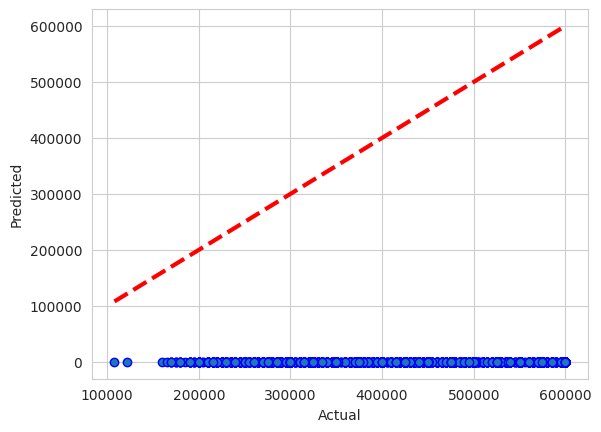

In [47]:
fig, ax = plt.subplots()
ax.scatter(y_test, best_estimator_pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [48]:
def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
    graph_model = model
    graph_model.set_params(**graph_params)
    graph_model.fit(X_train, y_train)
    y_pred_graph = model.predict(X_test)

    return model, y_pred_graph


best_model_count = 10 if not quick_mode else 2
best_model_count = 3 if not quick_mode else 1
best_models = {}
best_model_predictions = {}
best_model_scores = {}

showable_increment = total_fits // 4 if not quick_mode else 2
for i in range(0, total_fits, showable_increment):
    if debug_mode or True: print(f'{i} ==> {i}')

    if i == 0:
        fitted_graph_model = crossval_runner.best_estimator_
        y_pred_graph = y_pred
    else:
        graph_pipe_params = cv_results_df_sorted['params'][i]
        print (graph_pipe_params)
        # would always return the best! graph_pipe_params = cv_results_df_sorted.loc[cv_results_df_sorted['rank_test_score'] == 1, 'params'].values[0]

        graph_params = {}
        for key, value in graph_pipe_params.items():
            graph_params[key.replace('model__', '')] = value

        fitted_graph_model, y_pred_graph = custom_model_and_predictions(starter_pipe, graph_pipe_params, X_train,
                                                                        y_train, X_test)

    best_models[i] = fitted_graph_model[-1].get_params()
    best_model_predictions[i] = y_pred_graph
    best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

if debug_mode or True: print(f'{-1} ==> {-1}')
graph_pipe_params = cv_results_df_sorted['params'][total_fits - 1]
print (graph_pipe_params)
graph_params = {}
for key, value in graph_pipe_params.items():
    graph_params[key.replace('model__', '')] = value
fitted_graph_model, y_pred_graph = custom_model_and_predictions(starter_pipe, graph_pipe_params, X_train,
                                                                y_train, X_test)
best_models[-1] = fitted_graph_model[-1].get_params()
best_model_predictions[-1] = y_pred_graph
best_model_scores[-1] = fitted_graph_model.score(X_test, y_test)


ValueError: range() arg 3 must not be zero

In [49]:
cv_results_df_sorted

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,1000/20/mse/relu/normal/adam/1,1,0.342380,23.549170,0.485042,"{'model__batch_size': 1000, 'model__epochs': 2..."
1,1000/10/mse/relu/normal/adam/1,2,-5.322623,10.490758,0.360912,"{'model__batch_size': 1000, 'model__epochs': 1..."


In [50]:
cv_results_df_sorted['params']

0    {'model__batch_size': 1000, 'model__epochs': 2...
1    {'model__batch_size': 1000, 'model__epochs': 1...
Name: params, dtype: object

In [51]:
total_fits

2

In [52]:
best_models

{}

KeyError: -1

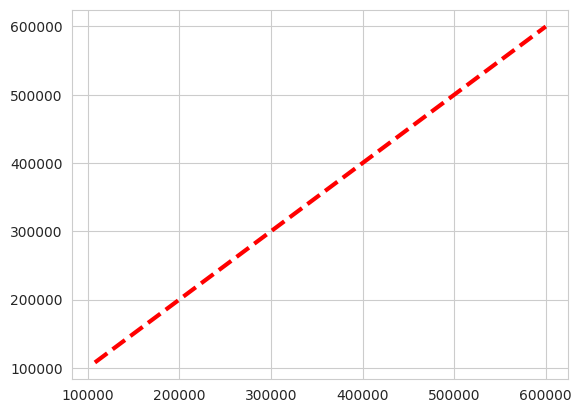

In [53]:
for i in best_model_scores.keys():
    if i >= 0:
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
        plt.scatter(y_test, best_model_predictions[i])
        # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
        plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i))
        plt.show()

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.scatter(y_test, best_model_predictions[-1])
# plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst) entry " + str(i))
plt.show()

In [ ]:
if True:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    fig.tight_layout()
    plt.show()

In [ ]:
cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
#cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
cv_best_model_fit_time

In [ ]:
# <catboost.core.CatBoostRegressor object at 0x7fb167387490>
# {'depth': 6}
# defaultdict(<class 'list'>, {'iterations': [0, 1, 2],
# 'test-RMSE-mean': [396884.9605444017, 359548.6632536235, 326027.84885587444],
# 'test-RMSE-std': [308.9495320039113, 260.0967808594464, 219.65856329246023],
# 'train-RMSE-mean': [396884.77936957515, 359542.3612912551, 326018.9404460669],
# 'train-RMSE-std': [91.44140078375503, 86.77961380623475, 69.4038638987425]})

cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"] if not_catboost else 999

DD2 = "(" + ",".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} - {ALGORITHM_DETAIL}{DD2} (v{VERSION})'.lower()

results = {
    '_score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    '_params': crossval_runner.best_params_ if not_catboost else cat_params,
    'run_env': run_env
}

if run_env not in ['colab']:
    results_json = get_results()
    this_model_is_best = update_results(results_json, results, key)

print(key, this_model_is_best, )

In [ ]:
crossval_runner.best_estimator_

In [ ]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
        if not_catboost:
            pickle.dump(crossval_runner.best_estimator_, f)
        else:
            pickle.dump(starter_model, f)
        print('pickled new version of model')
        print(results_json[key]['_score'], 'is new best score')
        #print(results_json[key]['_score'], 'is an improvement on', results_json[key]['second best score'])
else:
    print("not updated saved model, the previous run was better")
    print(results_json[key]['best score'], 'better than or equal to', results_json[key]['_score'])

In [ ]:
feature_importances = crossval_runner.best_estimator_[-1].feature_importances_
#std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

indices = np.argsort(feature_importances)[::-1]

print('Feature Ranking:')

for f in range(X_train.shape[1]):
    print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]),
          df_features.columns[indices[f] + 1])


In [ ]:
feature_importances = crossval_runner.best_estimator_[-1].feature_importances_
indices = np.argsort(feature_importances)

fig, ax = plt.subplots()
ax.barh(range(len(feature_importances)), feature_importances[indices])
ax.set_yticks(range(len(feature_importances)))
_ = ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])